In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

Number of samples (songs): 232725
Number of features (song properties): 18
Number of 'Pop' samples: 9386
Number of 'Classical' samples: 9256
Training set size: 14912 samples
Test set size: 3730 samples
Class distribution in training set: 7508 Pop, 7404 Classical
Class distribution in test set: 1878 Pop, 1852 Classical


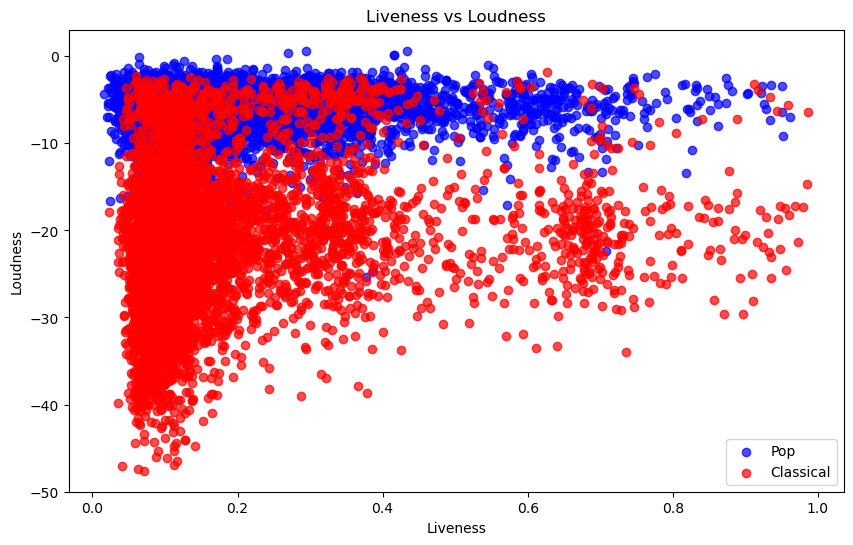

In [2]:
#1a Load the dataset and report the number of samples and features
# Load the dataset
data = pd.read_csv('SpotifyFeatures.csv')

# Display the number of samples and features
num_samples, num_features = data.shape
print(f"Number of samples (songs): {num_samples}")
print(f"Number of features (song properties): {num_features}")

#1b Retrieve samples for 'Pop' and 'Classical'
# Filter data for 'Pop' and 'Classical' genres and create a copy
pop_classical = data[(data['genre'] == 'Pop') | (data['genre'] == 'Classical')].copy()

# Create labels: 'Pop' = 1, 'Classical' = 0
pop_classical['label'] = pop_classical['genre'].apply(lambda x: 1 if x == 'Pop' else 0)

# Count the number of samples in each class
pop_count = pop_classical[pop_classical['genre'] == 'Pop'].shape[0]
classical_count = pop_classical[pop_classical['genre'] == 'Classical'].shape[0]
print(f"Number of 'Pop' samples: {pop_count}")
print(f"Number of 'Classical' samples: {classical_count}")

#1c Create numpy arrays for features and labels, split dataset into training and test sets
# Select the relevant features and labels
X = pop_classical[['liveness', 'loudness']].values
y = pop_classical['label'].values

# Get indices of 'Pop' and 'Classical' samples
pop_indices = np.where(y == 1)[0]
classical_indices = np.where(y == 0)[0]

# Shuffle the indices for 'Pop' and 'Classical' separately
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(pop_indices)
np.random.shuffle(classical_indices)

# Determine split index for both classes (80% training, 20% testing)
pop_split_index = int(0.8 * len(pop_indices))
classical_split_index = int(0.8 * len(classical_indices))

# Split the 'Pop' samples into training and test sets
pop_train_indices = pop_indices[:pop_split_index]
pop_test_indices = pop_indices[pop_split_index:]

# Split the 'Classical' samples into training and test sets
classical_train_indices = classical_indices[:classical_split_index]
classical_test_indices = classical_indices[classical_split_index:]

# Combine the training indices from both classes
train_indices = np.concatenate([pop_train_indices, classical_train_indices])

# Combine the test indices from both classes
test_indices = np.concatenate([pop_test_indices, classical_test_indices])

# Shuffle the training and test sets separately
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Create the final training and test datasets
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# Print the sizes of the training and test sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Print the distribution of classes in the training and test sets
print(f"Class distribution in training set: {sum(y_train == 1)} Pop, {sum(y_train == 0)} Classical")
print(f"Class distribution in test set: {sum(y_test == 1)} Pop, {sum(y_test == 0)} Classical")

#1d Plot the data on the liveness vs loudness plane
# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plot for Pop
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Pop', alpha=0.7)

# Scatter plot for Classical
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Classical', alpha=0.7)

# Labels and legend
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Liveness vs Loudness')
plt.legend()

# Show plot
plt.show()

Stopping early at epoch 54


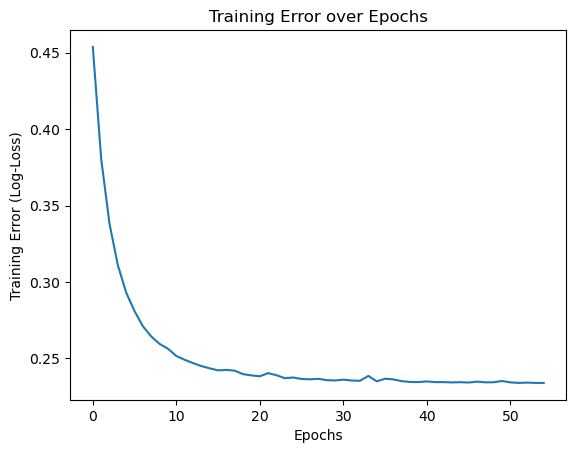

Training Accuracy: 92.74%
Test Accuracy: 92.20%


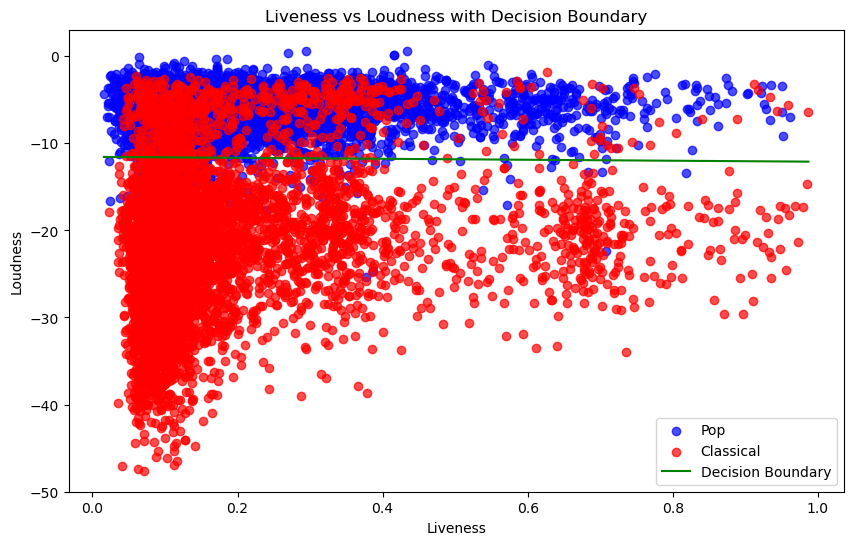

In [3]:
#2a Implement Logistic Regression using Stochastic Gradient Descent and plot training error
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=32):
        # Initialize learning rate, number of epochs, batch size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None  # Initialize weights to None
        self.bias = None  # Initialize bias to None
        self.training_errors = []  # List to store the training errors

    # Sigmoid activation function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # Fit the model to the training data using stochastic gradient descent
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Initialize weights to zero
        self.bias = 0  # Initialize bias to zero

        for epoch in range(self.epochs):
            indices = np.arange(n_samples)  # Create an array of sample indices
            np.random.shuffle(indices)  # Shuffle the indices to randomize the data
            
            # Split into mini-batches
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                # Linear model prediction (dot product of weights and features + bias)
                linear_model = np.dot(X_batch, self.weights) + self.bias
                y_predicted = self.sigmoid(linear_model)

                # Compute gradients for weights and bias
                dw = np.dot(X_batch.T, (y_predicted - y_batch)) / len(y_batch)
                db = np.sum(y_predicted - y_batch) / len(y_batch)

                # Update weights and bias using the gradients
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Compute the training error (log-loss) for the entire dataset
            y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
            loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
            self.training_errors.append(loss)

            # Early stopping if loss is not improving significantly
            if epoch > 1 and abs(self.training_errors[-2] - self.training_errors[-1]) < 1e-5:
                print(f"Stopping early at epoch {epoch}")
                break

        # Plot the training error as a function of epochs
        plt.plot(range(len(self.training_errors)), self.training_errors)
        plt.xlabel("Epochs")
        plt.ylabel("Training Error (Log-Loss)")
        plt.title("Training Error over Epochs")
        plt.show()

    # Predict the class labels for input data
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    # Compute the accuracy of the model
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

# Train and evaluate the optimized logistic regression model
learning_rate = 0.01
epochs = 1000
batch_size = 32  # Using mini-batches of size 32

model = LogisticRegressionSGD(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
model.fit(X_train, y_train)

#2b Test the logistic regression model on the test set and print accuracy
# Predict on the training set
y_train_pred = model.predict(X_train)
train_accuracy = model.accuracy(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Predict on the test set
y_test_pred = model.predict(X_test)
test_accuracy = model.accuracy(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#2c Plot the decision boundary using the learned logistic regression parameters
# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Pop', alpha=0.7)
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Classical', alpha=0.7)

# Plot the decision boundary (as a straight line)
x_values = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
y_values = -(model.weights[0] * x_values + model.bias) / model.weights[1]
plt.plot(x_values, y_values, label='Decision Boundary', color='green')

# Labels and legend
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Liveness vs Loudness with Decision Boundary')
plt.legend()

# Show plot
plt.show()

Confusion Matrix:
[[1649  203]
 [  88 1790]]


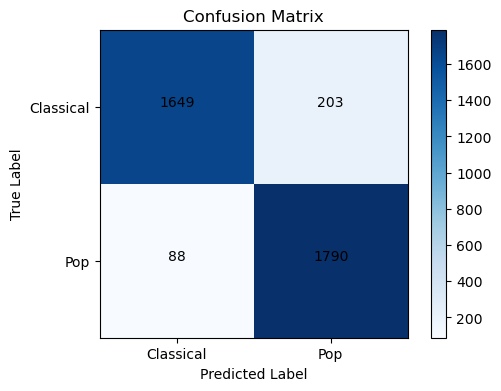

Test Accuracy: 92.20%


In [4]:
#3a Create a confusion matrix
# Create a confusion matrix using predictions from our model
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Report confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix using matplotlib
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classical', 'Pop'])
plt.yticks(tick_marks, ['Classical', 'Pop'])

# Labeling the matrix
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Annotate the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="black")

plt.show()

#3b Confusion matrix vs accuracy score
# Compute accuracy using the logistic regression implementation
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")